In [1]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from matplotlib import gridspec

from sklearn.preprocessing import scale



import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

from torch.utils.data import Dataset

from sklearn.utils import shuffle
from scipy.special import softmax

from PIL import Image

from PIL import ImageDraw

from skimage import morphology

import math

In [2]:
from tqdm import tqdm_notebook as tqdm

In [3]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = 36
plt.rcParams['ytick.labelsize'] = 36
plt.rcParams['legend.fontsize'] = 36
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=36
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

plt.rcParams["font.family"] = 'DejaVu Serif'

plt.rcParams['text.usetex'] = False

plt.rcParams['figure.figsize'] = (8.0, 8.0)

In [4]:
from MixtureLib.Mixture import MixtureEM
from MixtureLib.LocalModels import EachModelLinear
from MixtureLib.HyperModels import HyperExpertNN

from MixtureLib.Regularizers import RegularizeModel

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# All mixture of expert model

# Experiment

In [6]:
np.random.seed(0)
N = 100
N_noise=200
n = 3
r1 = 0.5
r2 = 1.5
phi = np.linspace(0, 2*np.pi, N)

x0 = 0
y0 = 0

# x = np.hstack([r1*np.sin(phi) + x0, r2*np.sin(phi) + x0])
x = np.hstack([r1*np.sin(phi) + x0, r2*np.sin(phi) + x0, 4*(np.random.rand(N_noise)-0.5) + x0])
x += 0.1*np.random.randn(x.shape[0])
# y = np.hstack([r1*np.cos(phi) + y0, r2*np.cos(phi) + y0])
y = np.hstack([r1*np.cos(phi) + y0, r2*np.cos(phi) + y0, 4*(np.random.rand(N_noise)-0.5) + y0])
y += 0.1*np.random.randn(y.shape[0])



In [7]:
image = Image.open('Picture/1.tif')

mask_1 = Image.open('Picture/1_mask_2.jpg').convert('L')
mask_1 = Image.fromarray((255*(np.array(mask_1) > 125)).astype(np.uint8))

In [8]:
x = np.array(np.where(np.array(mask_1) > 0)[1], dtype = np.float)
y = np.array(mask_1.size[0]-np.where(np.array(mask_1) > 0)[0], dtype = np.float)

x = scale(x)
y = scale(y)

x, y = shuffle(x, y, random_state = 0)

x = x[:200]
y = y[:200]

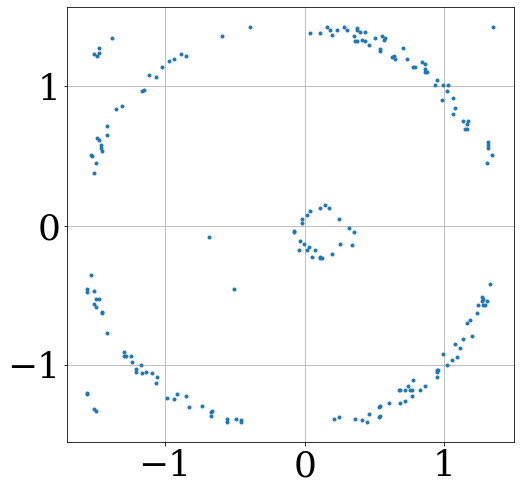

In [9]:
plt.plot(x, y, '.')

plt.grid()

plt.show()

In [10]:
X = np.vstack([x, y, np.ones_like(x)]).T
Y = x**2+y**2

In [11]:
X_tr = torch.FloatTensor(X)
Y_tr = torch.FloatTensor(Y).view([-1,1])

X_tr.shape, Y_tr.shape

(torch.Size([200, 3]), torch.Size([200, 1]))

In [12]:
K = 2
LIST_A = [torch.Tensor([1, 1, 1]) for _ in range(K)]
LIST_w = [torch.Tensor([[0], [0], [1]]), torch.Tensor([[0], [0], [2]])]


LoM = []
for k in range(K):
#     LoM.append(EachModelLinear(input_dim = n, device = device))
    LoM.append(EachModelLinear(input_dim = n, device = device, A = torch.ones(3)*LIST_A[k], w = torch.ones(3,1)*LIST_w[k]))

# K += 1
# LoM.append(RegularizeModel(ListOfModels = LoM))

HypPar = {'beta': 1.0, 'alpha': 1e-5}

HpMd = HyperExpertNN(input_dim = n, hidden_dim = 5, output_dim = K, device = device, epochs=1000)

Rg = RegularizeModel(ListOfModels = LoM, device=device)

model = MixtureEM(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, ListOfRegularizeModel = [Rg], device = device)
# model = MixtureEM(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, ListOfRegularizeModel = [], device = device)





In [13]:
%%time
model.fit(X_tr, Y_tr, 25, progress = tqdm)


CPU times: user 1min 6s, sys: 1.12 s, total: 1min 7s
Wall time: 1min 9s


In [14]:
model.HyperParameters

{'beta': tensor(0.1024), 'alpha': tensor(1.0000e-05)}

In [15]:
print(model.ListOfModels[0].A)

print(model.ListOfModels[1].A)

tensor([0.0395, 0.0082, 2.0078])
tensor([0.0873, 0.0000, 0.5419])


In [16]:
print(model.ListOfModels[0].B)

print(model.ListOfModels[1].B)

tensor([[ 0.0264, -0.0005, -0.0013],
        [-0.0005,  0.0080,  0.0007],
        [-0.0013,  0.0007,  0.0039]])
tensor([[ 5.5122e-04, -2.2098e-06,  9.9081e-06],
        [-2.2098e-06,  2.4060e-05, -7.7513e-08],
        [ 9.9081e-06, -7.7513e-08,  5.9168e-04]])


In [17]:
print(model.ListOfModels[0].w_0)

print(model.ListOfModels[1].w_0)

tensor([[-0.0003],
        [ 0.0004],
        [ 1.5001]])
tensor([[-0.0003],
        [ 0.0004],
        [ 1.5001]])


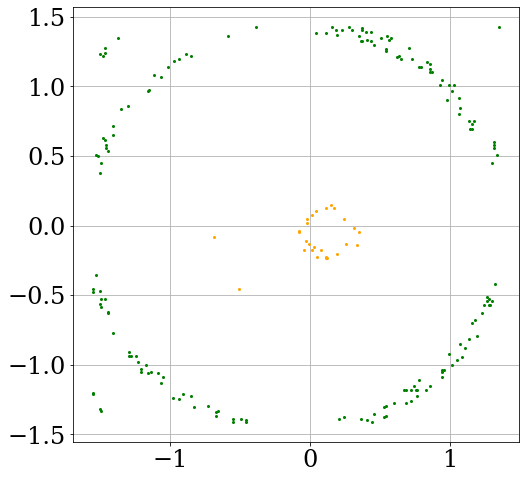

In [18]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

idx = np.argmax(model.predict(X_tr)[1], axis = 1)
t = np.linspace(0, 2*np.pi, 100)

colors = ['orange', 'green', 'red', 'yellow', 'blue']

for i in np.unique(idx):
    _ = plt.plot(x[idx == i], y[idx == i], '.', color = colors[i])
    
plt.grid()
plt.show()

In [19]:
TEMP = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])

TEMP

array([[-1.1470563e-01, -1.2074286e-02,  8.4548853e-02],
       [-2.9492018e-01,  5.7071779e-04,  2.2358835e+00]], dtype=float32)

In [20]:
CIRCLE = np.zeros_like(TEMP)

for i, param in enumerate(TEMP):
    x0, y0 = 0.5*param[:2]
    r = (param[2] + x0**2 + y0**2)**0.5
    CIRCLE[i] = x0, y0, r
    
CIRCLE

array([[-5.7352815e-02, -6.0371431e-03,  2.9643658e-01],
       [-1.4746009e-01,  2.8535890e-04,  1.5025405e+00]], dtype=float32)

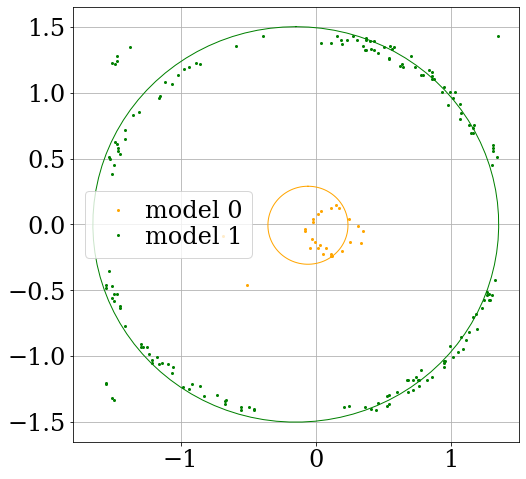

In [21]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

idx = np.argmax(model.predict(X_tr)[1], axis = 1)
t = np.linspace(0, 2*np.pi, 100)

colors = ['orange', 'green', 'red', 'yellow', 'blue']

for i in range(len(model.ListOfModels)):
    _ = plt.plot(x[idx == i], y[idx == i], '.', color = colors[i], label = 'model '+str(i))
    
    x0, y0, r = CIRCLE[i]
    x_plot = x0 + r*np.sin(t)
    y_plot = y0 + r*np.cos(t)
    
    _ = plt.plot(x_plot, y_plot, '-', color = colors[i])
    
plt.grid()

plt.legend(loc = 'best')

plt.show()